<a href="https://colab.research.google.com/github/yonghyuk0120/CNN_Study/blob/master/model/SE_ResNet50(torch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                                                                ↑↑↑↑↑↑
                                        위의 Open in Colab 을 누르면 훨씬 가독성 있게 볼 수 있습니다.

---
# 1. 패키지 로드
---

In [ ]:
!pip install --upgrade albumentations

In [ ]:
import numpy as np
import pandas as pd
import cv2
import sklearn
import albumentations as A
import torch.nn as nn
import math
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from tqdm import tqdm
from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline 

#device 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

---
# 2. 논문 분석

피쳐맵 블럭의 각 채널별의 중요도를 뽑아내서 , scale 시켜준다고 보면 된다. 채널 단위로 더 중요한 채널에 더 큰값을 스케일링 해주는  path를 만들어 표현의 quality를 높여주는 것

* 구조 및 원리
* 장점
* SE-ResNet 

---

## 1) 구조 및 원리

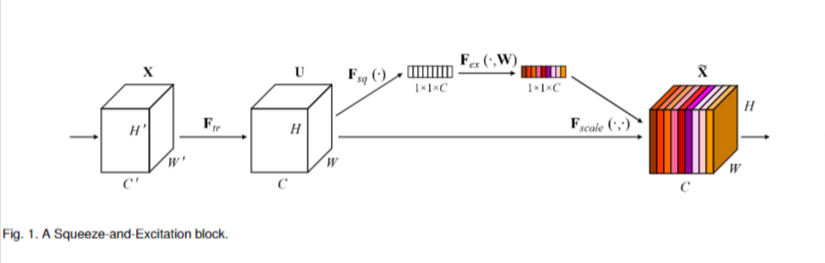

* SENet은 위의 그림과 같이 크게 Squeeze(쥐어짜는) 와 Excitation(자극) 부분으로 나누어져 있다. 직관적으로 이해 할 수 있는 쉬운 구조이다. 채널별로 풀링으로 쥐어짜서, 쥐어짠 정보의 가치들 끼리의 종속성과 각 채널의 중요도를 확인하고, 그것을 원래 자료에 적용하는 것 것.


#### squeeze block

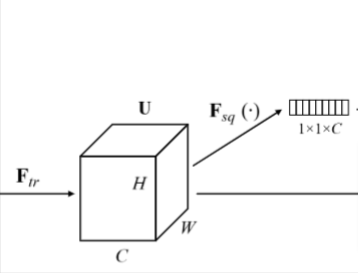

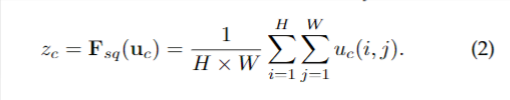

sq blcok은 위 그림에서 이 부분에 해당한다 F_sq(= 사실상 GAP) 를 통해서 내용을 쥐어짜는 것이다. 이렇게 쥐어짜서 channel descriptor (=an embedding of the global distribution ) 을 만들어낸다. 식이 적혀있지만 읽어보면 그냥 GAP의 식이다.

#### excitation

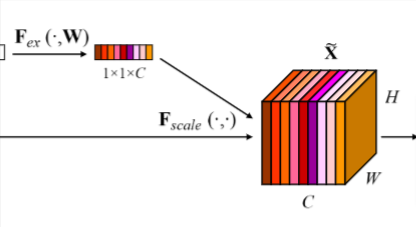

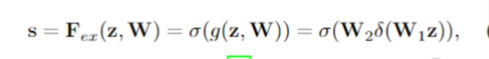

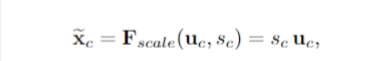

excitation 블럭은 sq블럭의 결과 값에 W1가중치를 곱하여 ReLU를 적용하고 다시 W2가중치를 곱하여 시그모이드를 적용하는 것이다. 이 방법으로 더 중요한 채널을 찾아내고 채널간의 종속석을 잡아 내는 것이다.

이 과정에서 이용할 함수들은 중요한 포인트가 있는데

1. 유연해야한다.(특히 nonlinear interaction을 학습할 수 있어야함)

2. 채널간 상호 배타적으로 학습하면 안 된다.

왜냐하면 목적이 단순히 어느 채널이 강한지를 보는 것이 아니라 여러 채널이 강조되는 것이기 때문이다.

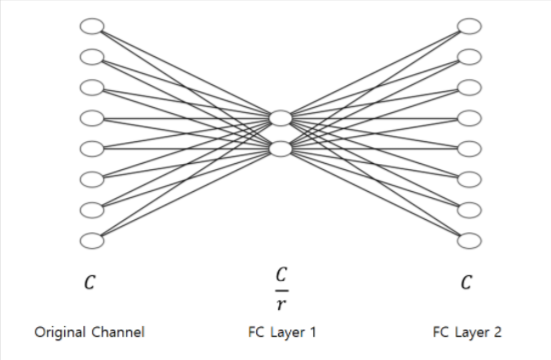

또한 구현 과정 중에 계산 복잡도를 줄이기 위해 W1 = C/r by C 이고, W2 = C by C/r 로 설정하여 채널의 수를 줄였다가 다시 원래대로

이 후 최종 결과물을 원래의 값에 곱하여 준다(스케일링)

## 장점

* 어느 네트워크에도 쉽게 가져다가 붙일 수 있다.
* 계산량(파라미터) 증가에 비해 모델의 성능 향상이 매우 크다.

## Resnet에 적용

다른 사람들은 주로 mobileNet에 구현했지만,

논문에서 제시한 내용은 inception과 resnet이므로, ResNet에 구현해보았음.

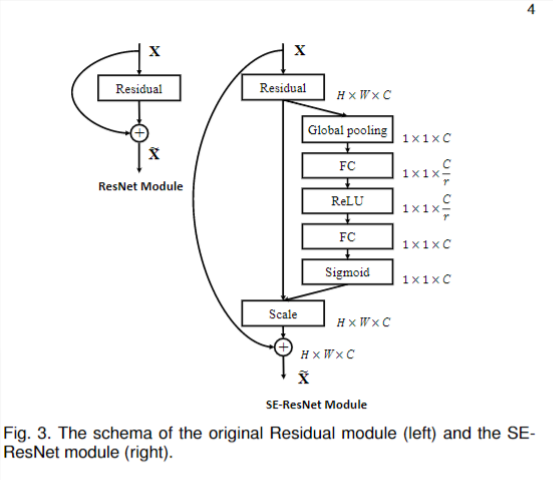


---


# 3. 구현




---







## SEBlock
이전에 레스넷을 구현한 것을 가져와서 path만 하나 SEblock의 path만 추가하면 된다.

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels // r),
            nn.ReLU(),
            nn.Linear(in_channels // r, in_channels),
            nn.Sigmoid()
        )
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.squeeze(x)
        x = self.flatten(x)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x

## ResNet에 결합

In [ ]:
class BasicBlock(nn.Module):
    """
    channels : [입력, 중간, 출력] 필터의 수를 원소 3개의 리스트로 받아온다.
    down : 필터사이즈를 절반으로 줄이고, 채널을 두배로 늘릴 것인지

    이것만 바꾸면 SEblock 적용 끝.
    """
    def __init__(self, channels, down = False, first = False):
        super(BasicBlock, self).__init__()
        layers = []
        down_shortcut = []
        self.down = down

        if first:
            down_shortcut.append(nn.Conv2d(channels[0], channels[2], kernel_size=1, bias = False))
            layers.append(nn.Conv2d(channels[0], channels[1], kernel_size=1, bias = False))
        else :
            down_shortcut.append(nn.Conv2d(channels[0], channels[2], kernel_size=1,stride = 2, bias = False))
            if down:
                layers.append(nn.Conv2d(channels[0], channels[1], kernel_size=1, stride=2, bias = False))
            else :
                layers.append(nn.Conv2d(channels[0], channels[1], kernel_size=1, bias = False))

        down_shortcut.append(nn.BatchNorm2d(channels[2]))


        layers.extend([
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),
            
            nn.Conv2d(channels[1], channels[1], kernel_size=3, stride=1, padding='same', bias = False),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),

            nn.Conv2d(channels[1], channels[2], kernel_size=1, bias = False),
            nn.BatchNorm2d(channels[2]),
         ])
        
        # SENet 추가.
        self.SEBlock = SEBlock(channels[2],16)

        self.block_layer = nn.Sequential(*layers)
        self.down_shortcut_block =  nn.Sequential(*down_shortcut)

    def forward(self, input_tensor):        
        if self.down :
            identity = self.down_shortcut_block(input_tensor)
            x = self.block_layer(input_tensor)
            x = self.SEBlock(x) * x
            # SEblock으로 스케일링
            x += identity
            output = nn.ReLU()(x)
        else :
            identity = input_tensor
            x = self.block_layer(input_tensor)
            x = self.SEBlock(x) * x
            # SEblock으로 스케일링
            x += identity
            output = nn.ReLU()(x)

        return output

       



# model = BasicBlock([64,64,256],True,True).to(device)
# summary(model, (64, 224,224))
# print(model)

model = BasicBlock([256,64,256]).to(device)
summary(model, (256, 224,224))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]          16,384
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,864
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7        [-1, 256, 224, 224]          16,384
       BatchNorm2d-8        [-1, 256, 224, 224]             512
 AdaptiveAvgPool2d-9            [-1, 256, 1, 1]               0
          Flatten-10                  [-1, 256]               0
           Linear-11                   [-1, 16]           4,112
             ReLU-12                   [-1, 16]               0
           Linear-13                  [-1, 256]           4,352
          Sigmoid-14                  [

## 블럭셋 구현
여러 개가 동시에 붙어있게

In [ ]:
class ResBlockSet(nn.Module):
    """
    기본블럭을 받아서 resnet블럭을 반복해서 쌓음.
    channels : [입력, 중간, 출력] 채널의 수를 원소 3개의 리스트로 받아온다.

    *주의: 중간에 들어가는 필터의 수가 아님! 처음 인자는 입력 인풋. 토치는 인풋 채널을 받음.
    *주의: 블럭셋 단위로 첫블럭은 이전 블럭의 출력이 아웃풋이고, 다음 블럭들은
    이번 블럭들의 아웃풋이 출력이다. 그래서 아래에 구현해놓았음(주석부분)
    *first는 block의 처음이 아니라 blockset 자체의 처음을 의미함(처음 한번만 수행)

    repeat : 반복수
    first : 처음 층은 사이즈를 줄이지 않으면서 받아온다.
    """
    def __init__(self, channels, repeat, first = False):
        super(ResBlockSet, self).__init__()        
        self.repeat = repeat
        layers = []

        if first:
            layers.append(BasicBlock([channels[0],channels[1],channels[2]],True,True))
        else:
            layers.append(BasicBlock([channels[0],channels[1],channels[2]],True,False))

        for i in range(repeat-1) :
            # 이 부분 중간 레스블럭은 커진놈을 받아서 줄였다가 다시 키움. 그래서 212로.
            # channels1은 입력채널의 수
            layers.append(BasicBlock([channels[2],channels[1],channels[2]]))

        self.blockset = nn.Sequential(*layers)




    def forward(self, input_tensor):
        return self.blockset(input_tensor)

model = ResBlockSet([64,64,256],3,True).to(device)
summary(model, (64, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 224, 224]          16,384
       BatchNorm2d-2        [-1, 256, 224, 224]             512
            Conv2d-3         [-1, 64, 224, 224]           4,096
       BatchNorm2d-4         [-1, 64, 224, 224]             128
              ReLU-5         [-1, 64, 224, 224]               0
            Conv2d-6         [-1, 64, 224, 224]          36,864
       BatchNorm2d-7         [-1, 64, 224, 224]             128
              ReLU-8         [-1, 64, 224, 224]               0
            Conv2d-9        [-1, 256, 224, 224]          16,384
      BatchNorm2d-10        [-1, 256, 224, 224]             512
AdaptiveAvgPool2d-11            [-1, 256, 1, 1]               0
          Flatten-12                  [-1, 256]               0
           Linear-13                   [-1, 16]           4,112
             ReLU-14                   

## SE-Resnet50 구현

In [ ]:
class SEResNet50(nn.Module):
    ''' resnet model을 만들어서 반환해준다'''
    def __init__(self, num_classes=1000):
        super(SEResNet50, self).__init__()        

        # 원본 conv1이 사이즈를 맞추기 위해 zeorpadding을 3으로 한번 1로 한번 함.
        # 나는 96짜리 넣을 거라 필요 없지만, 원본과 동일하게 가기로.
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride = 2,padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2,padding=1)                               
        )

        self.conv2 = ResBlockSet([64,64,256],3,True)
        self.conv3 = ResBlockSet([256,128,512],4)
        self.conv4 = ResBlockSet([512,256,1024],6)
        self.conv5 = ResBlockSet([1024,512,2048],3)
        self.gap =  nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.classifier =  nn.Linear(2048, num_classes)



        self._initialize_weights()



    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, input_tensor):
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)
        x = self.flatten(x) 
        # x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x


In [ ]:
# 모델 확인
model = SEResNet50().to(device)
summary(model, (3, 224,224))
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 4. 데이터 전처리

## 데이터 로드
 * 이미지 채크
 * STL10 (3,96,96)의 토치형식


  STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 

> 로딩식 수정
    


In [ ]:
trainset = torchvision.datasets.STL10(root='./data', split='test',
                                        download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.STL10(root='./data', split='train',
                                       download=True, transform= transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = trainset.classes

In [ ]:
batch_size = 7
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
classes = trainset.classes
# 클래스 정보 가져오기

In [ ]:
# trainloader.

In [ ]:
# 이미지를 보여주기 위한 함수
def show_images(images, labels, ncols=4):
    figure, axs = plt.subplots(figsize=(22, 4), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(np.transpose(images[i], (1, 2, 0)))
        # 차원이 바뀌므로 바꿔줘야함
        axs[i].set_title(classes[labels[i]])

In [ ]:
# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

(3, 96, 96)
torch.Size([3, 96, 96])


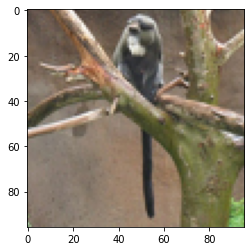

In [ ]:
# 잘 들어왔나 확인
# plt.imshow(trainset.data[1])
# STL은 애초에 데이터셋 자체가 텐서형식임((3, 96, 96))
# Totensor(데이터 로더를 통해)하면 알아서 차원까지 transpose해줌.
# cifar 경우 32 32 3 임. plt가 32,32,3 으로 받기 때문에 plt 통해 출력하려면 transpose가 필요
plt.imshow(np.transpose(trainset.data[1], (1, 2, 0)))

print(trainset.data[1].shape)
print(images[1].shape)

In [ ]:
print(trainset.data[1][1,:3,0:3])
print(images[1][1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1]/255)[1,:3,0:3])
print(transforms.ToTensor()(trainset.data[1])[1,:3,0:3])
# trainloader의 trasform을 거치는 것 만으로 0~1로 정규화된다.
# 아래 transform에서 평균과 표준편차로 나누는 것은 정확히는 표준화이다.
# totensor를 거치면 자동으로 0~1로 정규화 된다. 그리고 totensor 안에 transpose도 들어있는듯
# totensor안에 정규화가 들어있는데, 값이 이미 정규화되어있으면 하지 않음. 3,4번 라인비교


[[73 81 89]
 [71 79 86]
 [64 77 80]]
tensor([[0.2863, 0.3176, 0.3490],
        [0.2784, 0.3098, 0.3373],
        [0.2510, 0.3020, 0.3137]])
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]], dtype=torch.float64)
tensor([[0.3922, 0.3608, 0.3373],
        [0.3176, 0.3098, 0.3020],
        [0.2980, 0.2824, 0.2667]])


In [ ]:
# 아래처럼, loader안에 transpose 후 totensor하면 원하던 차원순서 312가 나옴
testnp = np.zeros((3,1,2))
print(testnp.shape)
print(transforms.ToTensor()(testnp).shape)
print(np.transpose(testnp, (1, 2, 0)).shape)
print(transforms.ToTensor()(np.transpose(testnp, (1, 2, 0))).shape)

(3, 1, 2)
torch.Size([2, 3, 1])
(1, 2, 3)
torch.Size([3, 1, 2])


In [ ]:
print(trainset.data[1].shape)
print(images[1].shape)
print(transforms.ToTensor()(trainset.data[1]).shape)

# totansor뿐만아니라 loader까지 거쳐야 원하는 차원으로 나오는듯
# 아마 로더에 차원 변경이 구현되어있는듯
# 아래 커스텀 모델에 이것도 구현해야함.

(3, 96, 96)
torch.Size([3, 96, 96])
torch.Size([96, 3, 96])


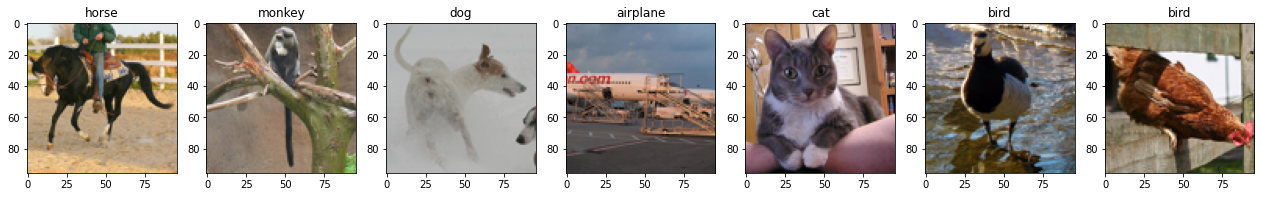

In [ ]:
# 이미지 보여주기
show_images(images,labels,7)

In [ ]:
images[1][1,1,1]

tensor(0.3098)

In [ ]:
aa = np.transpose(trainset.data[1], (1, 2, 0))
print(transforms.ToTensor()(aa).shape)

torch.Size([3, 96, 96])


## 커스텀 데이터셋 구현
* albumentations을 사용하기 위해서 커스텀 데이터 셋을 구현한다.
* 파이토치 텐서플로우 전부 이미지를 배치단위로 cpu,gpu 옮기는 과정에 병목이 있다고 알고있음. 즉, tf나 torch나 데이터 파이프 라인을 그대로 쓰는 것 보다 albumentations을 이용하는 것이 훨씬빠름.




In [ ]:
# 커스텀 데이터(albumenatation 적용)
class ForAlbuSet(Dataset):
    def __init__(self, dataset, transform = None ,data_type = "train" ):
        self.dataset = dataset
        self.transform = transform
        self.data_type = data_type


    def __len__(self):
        return self.dataset.data.shape[0]

    def __getitem__(self, index):
        image = self.dataset.data[index]
        image = np.transpose(image, (1, 2, 0))
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 위옵션은 cv2.imread에서 필요함
        label = self.dataset.labels[index]
        # CIFAR에서는 데이터셋 안에 label이 아니라 target으로 적혀있음.
        # CIFAR는 int반환이지만 얘는 numpy.unit8
        # label과 image를 output 결과와 통일 시켜야함(int,long, float, double 등등)
        # 형변환은 train에서 구현 : 데이터셋과 상관없이 항상 필요한 작업

        
        if self.data_type == "train" : 
            # random_n = np.random.randint(148,256)
            # image = cv2.resize(image, (random_n,random_n))
            # resize로 멀티스케일을 작게나마 구현 해보았음
            # 다만 너무 계산시간이 커진다.


            if self.transform is not None:
                image = self.transform(image=image)["image"]        
        else :

            if self.transform is not None:
                image = self.transform(image=image)["image"]


        return image, label
    

## 증강(transform)

* 토치의 transform 사용시에는 to 텐서 다음에 노말 하기. totensor를 해야 값들이 0\~1사이로감. 그래야 imagenet 평균과 표준편차를 사용가능(0\~255가 아니라 0~1이니까)
    > albumentation은 구현코드를 확인해보면, normalize안에 자동으로 255로 나눠서 구현되어있음.


* torchvision.transforms.(채널, 세로, 가로) 과 달리 Albu.transforms 는 array 기준으로 작업함(세로,가로,채널)
* cv2는 (가로,세로,채널)

* (주의) totensor없으면 loader가 작동 안 함.(차원 순서 바뀌기 때문)

* 실험과정에서 성능이 좋지않아서 논문과 다른 장치들을 넣었음.

In [ ]:
augmentor_tr = A.Compose([        
    # A.Resize(232,232),
    A.Resize(224,224),                
    # A.FancyPCA(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.ShiftScaleRotate(scale_limit=(0.7, 0.9), p=0.5, rotate_limit=30),
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=0.5),
    A.Blur(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

augmentor_test = A.Compose([
    A.Resize(224,224),                            
    A.Normalize(),
    ToTensorV2()
])

## 분할

* random_split이 Torch.utils.data.dataset.random_split에도 있는데, 이건 제대로 작동 안 하니까 조심, random_split은 분할을 하지만 원본을 그대로 두고 랜덤인덱스로 불러오는 원리.아마 메모리 관리를 위해 이렇게 구현한듯

* STL10 데이터는 테스트가 8000개고 트레인이 5000개 이다. 테스트가 트레인보다 많으므로, test데이터로 train에쓰고 train 데이터로 테스트에 쓰자. 트레인 데이터가 더 많아야 한다. 
    > 위의 로딩식 수정했음. 
    
* 또한 분할을 이용해서 5000개를 3000/2000으로 나누어 validation과 test를 하자.

In [ ]:
val_ratio = 0.6
val_size = round(len(testset)*val_ratio)
test_size = len(testset) - val_size
                    
val_set, test_set= random_split(
    testset,
    [val_size,test_size],
    generator=torch.Generator().manual_seed(20)
    )

In [ ]:
# 분할 채크
len(val_set)

3000

In [ ]:
ab_train_set = ForAlbuSet(trainset, transform=augmentor_tr)
ab_val_set = ForAlbuSet(val_set.dataset, transform=augmentor_test, data_type= 'val')
ab_test_set = ForAlbuSet(test_set.dataset, transform=augmentor_test, data_type= 'test')


In [ ]:
batch_size = 64
train_loader = DataLoader(ab_train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_loader = DataLoader(ab_val_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_loader = DataLoader(ab_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)




# 5. 학습 및 평가

**구현목표**
* 정확도 metric 구현 
* 로스, 정확도 동시에 출력
* 콜백(reducelr, earlystop)
* 작업진행도 모니터링 출력
* 테스트 loss 변화 그래프로 출력
* train, vaildate, fit 구현



## early stopping class 정의

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0

        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')

        self.val_loss_min = val_loss

## train, validate, fit, test 함수 정의

In [ ]:
def train(model,train_loader, criterion, optimizer, epoch):
    model.train()
    stream = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for images, target in stream:
        images = images.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()

        output = model(images)
        sum_loss = criterion(output, target)
        loss = sum_loss/len(target)
        # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
        # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.



        loss.backward()
        optimizer.step()

        # 로스합
        train_loss +=sum_loss.item()

        # 정확도 계산
        pred = output.max(dim = 1,keepdim = True)[1]
        correct += (target.view(-1, 1) == pred).sum().item()


        stream.set_description(
            f"Epoch: {epoch}. Train."
        )
        

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [ ]:
def validate(model, val_loader, criterion, epoch):
    model.eval()
    stream = tqdm(val_loader)
    val_loss = 0
    correct = 0

    with torch.no_grad():
        for images, target in stream:
            images = images.to(device).float()
            target = target.to(device).long()

            output = model(images)
            sum_loss = criterion(output, target)
            loss = sum_loss/len(target)
            # criterion 에 mean옵션(default)를 주면 되지만 sum을 이용한 loss 합이 필요함.(출력위해서)
            # 이상하게 sum옵션으로 하면 학습이 되지 않음. 수동으로 mean 구현하고 sum이용.

            # 로스합
            val_loss +=sum_loss.item()

            # 정확도 계산
            pred = output.max(dim = 1,keepdim = True)[1]
            correct += (target.view(-1, 1) == pred).sum().item()




            stream.set_description(
                f"Epoch: {epoch}. Validate."
            )
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)

    return val_loss, val_accuracy

In [ ]:
def fit(model,train_loader,val_loader,criterion,optimizer,epoch, early_stopping=None, scheduler=None):
 
    # epoch당 average loss를 track하기 위한 list
    avg_train_losses = []
    avg_val_losses = []
    avg_train_accuracy = []
    avg_val_accuracy = []

    for i in range(1, epoch + 1):
        train_loss ,train_accuracy =train( model,train_loader, criterion, optimizer, i)
        print(f"[{i}] Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")
        val_loss ,val_accuracy = validate( model,val_loader, criterion, i)
        if i == epoch :
            sleep(0.1)
            # 마지막 출력에서 tqdm이 업데이트 되기전에 아래 출력값이 나오지 않도록.
            # 다른 줄에 아래값이 나올 수 있게 해줌
        print(f"[{i}] Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")


        
        if scheduler is not None :
            # scheduler.step()
            scheduler.step(val_loss) 
            # 아래는 reducelronplateau 전용
            

        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        avg_train_accuracy.append(train_accuracy)
        avg_val_accuracy.append(val_accuracy)

        
        if early_stopping is not None :
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print()
                print("Early stopping")
                sleep(0.1)
                break

        print()

                         
    return  model, avg_train_losses, avg_val_losses,  avg_train_accuracy , avg_val_accuracy


In [ ]:
def test(model, test_loader, criterion):
    test_loss ,test_accuracy = validate( model,test_loader, criterion, 1)
    sleep(0.1)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")
    
    return (test_loss ,test_accuracy)

## 학습

In [ ]:
model = SEResNet50(10).to(device)

In [ ]:
# loss function의 정의(CrossEntropyLoss)
criterion = nn.CrossEntropyLoss(reduction='sum')

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 스케쥴러
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


# early_stopping
early_stopping = EarlyStopping(patience = 15, verbose = True)

In [ ]:
model, train_loss, val_loss ,train_accuracy ,val_accuracy= fit(model,train_loader,val_loader,criterion,optimizer,100,early_stopping,scheduler)

Epoch: 1. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[1] Train Loss: 1.9168, Accuracy: 26.59%


Epoch: 1. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[1] Validation Loss: 1.6984, Accuracy: 35.60%
Validation loss decreased (inf --> 1.698412).



Epoch: 2. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[2] Train Loss: 1.7017, Accuracy: 34.69%


Epoch: 2. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[2] Validation Loss: 1.7929, Accuracy: 34.70%
EarlyStopping counter: 1 out of 15



Epoch: 3. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[3] Train Loss: 1.6338, Accuracy: 38.10%


Epoch: 3. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[3] Validation Loss: 1.4993, Accuracy: 44.28%
Validation loss decreased (1.698412 --> 1.499272).



Epoch: 4. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[4] Train Loss: 1.5622, Accuracy: 41.50%


Epoch: 4. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[4] Validation Loss: 1.4605, Accuracy: 44.86%
Validation loss decreased (1.499272 --> 1.460543).



Epoch: 5. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[5] Train Loss: 1.4873, Accuracy: 44.41%


Epoch: 5. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[5] Validation Loss: 1.7198, Accuracy: 42.02%
EarlyStopping counter: 1 out of 15



Epoch: 6. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[6] Train Loss: 1.4349, Accuracy: 46.35%


Epoch: 6. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[6] Validation Loss: 1.4510, Accuracy: 45.56%
Validation loss decreased (1.460543 --> 1.450954).



Epoch: 7. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[7] Train Loss: 1.3971, Accuracy: 48.04%


Epoch: 7. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[7] Validation Loss: 1.3211, Accuracy: 48.88%
Validation loss decreased (1.450954 --> 1.321130).



Epoch: 8. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[8] Train Loss: 1.3392, Accuracy: 50.55%


Epoch: 8. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[8] Validation Loss: 1.2907, Accuracy: 52.64%
Validation loss decreased (1.321130 --> 1.290719).



Epoch: 9. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[9] Train Loss: 1.3122, Accuracy: 51.41%


Epoch: 9. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[9] Validation Loss: 1.3147, Accuracy: 50.06%
EarlyStopping counter: 1 out of 15



Epoch: 10. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[10] Train Loss: 1.2685, Accuracy: 53.19%


Epoch: 10. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[10] Validation Loss: 1.2785, Accuracy: 51.30%
Validation loss decreased (1.290719 --> 1.278527).



Epoch: 11. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[11] Train Loss: 1.2131, Accuracy: 55.67%


Epoch: 11. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[11] Validation Loss: 1.3411, Accuracy: 52.58%
EarlyStopping counter: 1 out of 15



Epoch: 12. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[12] Train Loss: 1.2190, Accuracy: 55.74%


Epoch: 12. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[12] Validation Loss: 1.1740, Accuracy: 55.82%
Validation loss decreased (1.278527 --> 1.174003).



Epoch: 13. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[13] Train Loss: 1.1581, Accuracy: 58.11%


Epoch: 13. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[13] Validation Loss: 1.1973, Accuracy: 56.86%
EarlyStopping counter: 1 out of 15



Epoch: 14. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[14] Train Loss: 1.1448, Accuracy: 58.52%


Epoch: 14. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[14] Validation Loss: 1.1761, Accuracy: 57.60%
EarlyStopping counter: 2 out of 15



Epoch: 15. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[15] Train Loss: 1.0928, Accuracy: 60.76%


Epoch: 15. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[15] Validation Loss: 1.3694, Accuracy: 53.18%
EarlyStopping counter: 3 out of 15



Epoch: 16. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[16] Train Loss: 1.0611, Accuracy: 62.01%


Epoch: 16. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[16] Validation Loss: 1.1161, Accuracy: 60.98%
Validation loss decreased (1.174003 --> 1.116064).



Epoch: 17. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[17] Train Loss: 1.0297, Accuracy: 62.60%


Epoch: 17. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[17] Validation Loss: 1.1201, Accuracy: 59.90%
EarlyStopping counter: 1 out of 15



Epoch: 18. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.38s/it]


[18] Train Loss: 1.0278, Accuracy: 63.06%


Epoch: 18. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[18] Validation Loss: 1.0478, Accuracy: 62.48%
Validation loss decreased (1.116064 --> 1.047794).



Epoch: 19. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.38s/it]


[19] Train Loss: 0.9949, Accuracy: 64.17%


Epoch: 19. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[19] Validation Loss: 1.1462, Accuracy: 60.62%
EarlyStopping counter: 1 out of 15



Epoch: 20. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.38s/it]


[20] Train Loss: 0.9705, Accuracy: 64.71%


Epoch: 20. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[20] Validation Loss: 1.0765, Accuracy: 61.30%
EarlyStopping counter: 2 out of 15



Epoch: 21. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.38s/it]


[21] Train Loss: 0.9443, Accuracy: 65.90%


Epoch: 21. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[21] Validation Loss: 1.0619, Accuracy: 63.78%
EarlyStopping counter: 3 out of 15



Epoch: 22. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[22] Train Loss: 0.9317, Accuracy: 66.88%


Epoch: 22. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[22] Validation Loss: 1.0287, Accuracy: 65.48%
Validation loss decreased (1.047794 --> 1.028746).



Epoch: 23. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[23] Train Loss: 0.9093, Accuracy: 67.66%


Epoch: 23. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[23] Validation Loss: 1.1522, Accuracy: 62.64%
EarlyStopping counter: 1 out of 15



Epoch: 24. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[24] Train Loss: 0.8778, Accuracy: 68.58%


Epoch: 24. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[24] Validation Loss: 0.9413, Accuracy: 67.64%
Validation loss decreased (1.028746 --> 0.941281).



Epoch: 25. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[25] Train Loss: 0.8628, Accuracy: 68.70%


Epoch: 25. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[25] Validation Loss: 1.1325, Accuracy: 61.84%
EarlyStopping counter: 1 out of 15



Epoch: 26. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[26] Train Loss: 0.8590, Accuracy: 69.41%


Epoch: 26. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[26] Validation Loss: 1.0107, Accuracy: 65.78%
EarlyStopping counter: 2 out of 15



Epoch: 27. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[27] Train Loss: 0.8315, Accuracy: 69.85%


Epoch: 27. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[27] Validation Loss: 1.0160, Accuracy: 65.12%
EarlyStopping counter: 3 out of 15



Epoch: 28. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[28] Train Loss: 0.8097, Accuracy: 70.81%


Epoch: 28. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[28] Validation Loss: 0.9504, Accuracy: 66.72%
EarlyStopping counter: 4 out of 15



Epoch: 29. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.38s/it]


[29] Train Loss: 0.7870, Accuracy: 72.30%


Epoch: 29. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[29] Validation Loss: 0.9633, Accuracy: 68.16%
EarlyStopping counter: 5 out of 15



Epoch: 30. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[30] Train Loss: 0.7791, Accuracy: 72.19%


Epoch: 30. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[30] Validation Loss: 1.0593, Accuracy: 65.80%
EarlyStopping counter: 6 out of 15



Epoch: 31. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[31] Train Loss: 0.7641, Accuracy: 73.24%


Epoch: 31. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[31] Validation Loss: 0.9038, Accuracy: 67.94%
Validation loss decreased (0.941281 --> 0.903759).



Epoch: 32. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[32] Train Loss: 0.7499, Accuracy: 73.20%


Epoch: 32. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[32] Validation Loss: 0.9179, Accuracy: 69.48%
EarlyStopping counter: 1 out of 15



Epoch: 33. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[33] Train Loss: 0.7156, Accuracy: 74.36%


Epoch: 33. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[33] Validation Loss: 1.0393, Accuracy: 67.44%
EarlyStopping counter: 2 out of 15



Epoch: 34. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[34] Train Loss: 0.7350, Accuracy: 73.55%


Epoch: 34. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[34] Validation Loss: 1.0359, Accuracy: 67.04%
EarlyStopping counter: 3 out of 15



Epoch: 35. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[35] Train Loss: 0.6985, Accuracy: 75.04%


Epoch: 35. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[35] Validation Loss: 1.0170, Accuracy: 68.20%
EarlyStopping counter: 4 out of 15



Epoch: 36. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[36] Train Loss: 0.6893, Accuracy: 75.79%


Epoch: 36. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[36] Validation Loss: 1.0914, Accuracy: 65.26%
EarlyStopping counter: 5 out of 15



Epoch: 37. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[37] Train Loss: 0.6905, Accuracy: 75.01%


Epoch: 37. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.30it/s]


[37] Validation Loss: 0.9580, Accuracy: 68.52%
EarlyStopping counter: 6 out of 15



Epoch: 38. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[38] Train Loss: 0.6676, Accuracy: 75.72%


Epoch: 38. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.30it/s]


[38] Validation Loss: 1.3405, Accuracy: 62.54%
EarlyStopping counter: 7 out of 15



Epoch: 39. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[39] Train Loss: 0.6367, Accuracy: 77.24%


Epoch: 39. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.31it/s]


[39] Validation Loss: 1.0205, Accuracy: 68.76%
EarlyStopping counter: 8 out of 15



Epoch: 40. Train.: 100%|██████████| 125/125 [02:52<00:00,  1.38s/it]


[40] Train Loss: 0.6550, Accuracy: 76.35%


Epoch: 40. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[40] Validation Loss: 0.9120, Accuracy: 71.12%
EarlyStopping counter: 9 out of 15



Epoch: 41. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[41] Train Loss: 0.6315, Accuracy: 77.67%


Epoch: 41. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[41] Validation Loss: 0.8900, Accuracy: 70.14%
Validation loss decreased (0.903759 --> 0.890032).



Epoch: 42. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[42] Train Loss: 0.6056, Accuracy: 78.54%


Epoch: 42. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[42] Validation Loss: 0.9378, Accuracy: 70.62%
EarlyStopping counter: 1 out of 15



Epoch: 43. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[43] Train Loss: 0.6032, Accuracy: 78.40%


Epoch: 43. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[43] Validation Loss: 0.9529, Accuracy: 69.44%
EarlyStopping counter: 2 out of 15



Epoch: 44. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[44] Train Loss: 0.5967, Accuracy: 79.03%


Epoch: 44. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[44] Validation Loss: 0.9884, Accuracy: 71.54%
EarlyStopping counter: 3 out of 15



Epoch: 45. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[45] Train Loss: 0.5649, Accuracy: 80.44%


Epoch: 45. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[45] Validation Loss: 0.9831, Accuracy: 69.84%
EarlyStopping counter: 4 out of 15



Epoch: 46. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[46] Train Loss: 0.5728, Accuracy: 79.95%


Epoch: 46. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[46] Validation Loss: 0.9308, Accuracy: 71.28%
EarlyStopping counter: 5 out of 15



Epoch: 47. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[47] Train Loss: 0.5730, Accuracy: 79.99%


Epoch: 47. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[47] Validation Loss: 1.0282, Accuracy: 69.88%
EarlyStopping counter: 6 out of 15



Epoch: 48. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[48] Train Loss: 0.5799, Accuracy: 79.40%


Epoch: 48. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[48] Validation Loss: 0.8914, Accuracy: 73.04%
EarlyStopping counter: 7 out of 15



Epoch: 49. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[49] Train Loss: 0.5298, Accuracy: 81.39%


Epoch: 49. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[49] Validation Loss: 0.8348, Accuracy: 73.54%
Validation loss decreased (0.890032 --> 0.834806).



Epoch: 50. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[50] Train Loss: 0.5440, Accuracy: 80.47%


Epoch: 50. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[50] Validation Loss: 1.0629, Accuracy: 67.80%
EarlyStopping counter: 1 out of 15



Epoch: 51. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[51] Train Loss: 0.5392, Accuracy: 80.89%


Epoch: 51. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[51] Validation Loss: 1.0358, Accuracy: 71.16%
EarlyStopping counter: 2 out of 15



Epoch: 52. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[52] Train Loss: 0.5056, Accuracy: 82.28%


Epoch: 52. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[52] Validation Loss: 0.9399, Accuracy: 73.38%
EarlyStopping counter: 3 out of 15



Epoch: 53. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[53] Train Loss: 0.5324, Accuracy: 81.24%


Epoch: 53. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[53] Validation Loss: 0.9718, Accuracy: 71.84%
EarlyStopping counter: 4 out of 15



Epoch: 54. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[54] Train Loss: 0.4926, Accuracy: 82.58%


Epoch: 54. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[54] Validation Loss: 0.8969, Accuracy: 73.24%
EarlyStopping counter: 5 out of 15



Epoch: 55. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[55] Train Loss: 0.5045, Accuracy: 82.09%


Epoch: 55. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[55] Validation Loss: 0.9457, Accuracy: 71.60%
EarlyStopping counter: 6 out of 15



Epoch: 56. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[56] Train Loss: 0.4887, Accuracy: 82.60%


Epoch: 56. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[56] Validation Loss: 1.0568, Accuracy: 70.14%
EarlyStopping counter: 7 out of 15



Epoch: 57. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[57] Train Loss: 0.4980, Accuracy: 82.14%


Epoch: 57. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[57] Validation Loss: 0.9264, Accuracy: 72.92%
EarlyStopping counter: 8 out of 15



Epoch: 58. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[58] Train Loss: 0.4894, Accuracy: 83.00%


Epoch: 58. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[58] Validation Loss: 0.9761, Accuracy: 71.70%
EarlyStopping counter: 9 out of 15



Epoch: 59. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[59] Train Loss: 0.4560, Accuracy: 83.58%


Epoch: 59. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.32it/s]


[59] Validation Loss: 1.0163, Accuracy: 72.30%
EarlyStopping counter: 10 out of 15



Epoch: 60. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[60] Train Loss: 0.4475, Accuracy: 84.34%


Epoch: 60. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[60] Validation Loss: 0.9781, Accuracy: 71.80%
Epoch    60: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 11 out of 15



Epoch: 61. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[61] Train Loss: 0.3808, Accuracy: 86.91%


Epoch: 61. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[61] Validation Loss: 0.7712, Accuracy: 77.52%
Validation loss decreased (0.834806 --> 0.771157).



Epoch: 62. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[62] Train Loss: 0.3313, Accuracy: 88.56%


Epoch: 62. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[62] Validation Loss: 0.7697, Accuracy: 77.58%
Validation loss decreased (0.771157 --> 0.769661).



Epoch: 63. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[63] Train Loss: 0.3216, Accuracy: 88.96%


Epoch: 63. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[63] Validation Loss: 0.7732, Accuracy: 77.96%
EarlyStopping counter: 1 out of 15



Epoch: 64. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[64] Train Loss: 0.3150, Accuracy: 89.59%


Epoch: 64. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[64] Validation Loss: 0.7699, Accuracy: 77.78%
EarlyStopping counter: 2 out of 15



Epoch: 65. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[65] Train Loss: 0.2997, Accuracy: 89.96%


Epoch: 65. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[65] Validation Loss: 0.7579, Accuracy: 77.74%
Validation loss decreased (0.769661 --> 0.757917).



Epoch: 66. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[66] Train Loss: 0.3055, Accuracy: 89.33%


Epoch: 66. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[66] Validation Loss: 0.7666, Accuracy: 78.20%
EarlyStopping counter: 1 out of 15



Epoch: 67. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[67] Train Loss: 0.2990, Accuracy: 89.88%


Epoch: 67. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[67] Validation Loss: 0.7709, Accuracy: 78.32%
EarlyStopping counter: 2 out of 15



Epoch: 68. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[68] Train Loss: 0.2926, Accuracy: 90.04%


Epoch: 68. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[68] Validation Loss: 0.7847, Accuracy: 78.30%
EarlyStopping counter: 3 out of 15



Epoch: 69. Train.: 100%|██████████| 125/125 [02:51<00:00,  1.37s/it]


[69] Train Loss: 0.2899, Accuracy: 90.14%


Epoch: 69. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[69] Validation Loss: 0.8056, Accuracy: 77.56%
EarlyStopping counter: 4 out of 15



Epoch: 70. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[70] Train Loss: 0.2931, Accuracy: 89.85%


Epoch: 70. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[70] Validation Loss: 0.7898, Accuracy: 77.90%
EarlyStopping counter: 5 out of 15



Epoch: 71. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[71] Train Loss: 0.2851, Accuracy: 90.06%


Epoch: 71. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[71] Validation Loss: 0.7866, Accuracy: 77.86%
EarlyStopping counter: 6 out of 15



Epoch: 72. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[72] Train Loss: 0.2827, Accuracy: 89.85%


Epoch: 72. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[72] Validation Loss: 0.7970, Accuracy: 77.56%
EarlyStopping counter: 7 out of 15



Epoch: 73. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[73] Train Loss: 0.2791, Accuracy: 90.53%


Epoch: 73. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[73] Validation Loss: 0.8103, Accuracy: 78.14%
EarlyStopping counter: 8 out of 15



Epoch: 74. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[74] Train Loss: 0.2759, Accuracy: 90.28%


Epoch: 74. Validate.: 100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


[74] Validation Loss: 0.8003, Accuracy: 78.12%
EarlyStopping counter: 9 out of 15



Epoch: 75. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[75] Train Loss: 0.2684, Accuracy: 90.65%


Epoch: 75. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[75] Validation Loss: 0.8043, Accuracy: 78.44%
EarlyStopping counter: 10 out of 15



Epoch: 76. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[76] Train Loss: 0.2675, Accuracy: 90.99%


Epoch: 76. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[76] Validation Loss: 0.8053, Accuracy: 78.34%
Epoch    76: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 11 out of 15



Epoch: 77. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[77] Train Loss: 0.2597, Accuracy: 90.95%


Epoch: 77. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[77] Validation Loss: 0.8074, Accuracy: 78.28%
EarlyStopping counter: 12 out of 15



Epoch: 78. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[78] Train Loss: 0.2392, Accuracy: 91.67%


Epoch: 78. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[78] Validation Loss: 0.7898, Accuracy: 78.62%
EarlyStopping counter: 13 out of 15



Epoch: 79. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[79] Train Loss: 0.2526, Accuracy: 91.49%


Epoch: 79. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[79] Validation Loss: 0.8060, Accuracy: 78.52%
EarlyStopping counter: 14 out of 15



Epoch: 80. Train.: 100%|██████████| 125/125 [02:50<00:00,  1.37s/it]


[80] Train Loss: 0.2632, Accuracy: 91.03%


Epoch: 80. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.33it/s]


[80] Validation Loss: 0.8001, Accuracy: 78.72%
EarlyStopping counter: 15 out of 15

Early stopping


## 평가

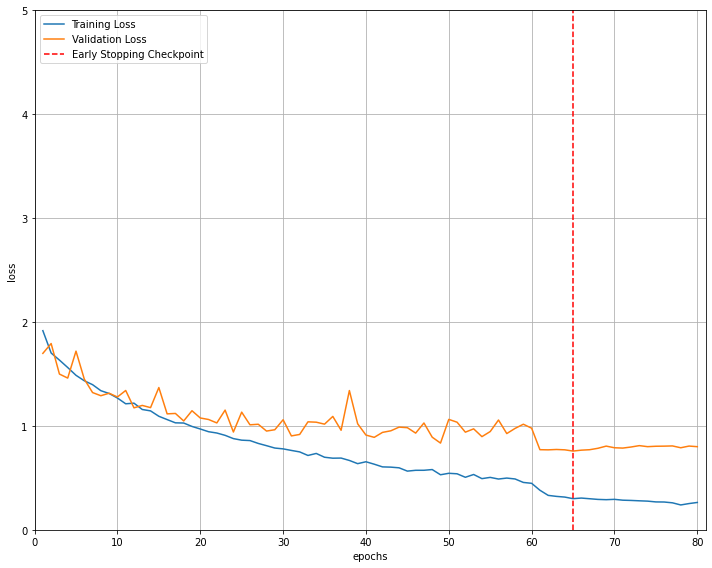

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(val_loss)+1),val_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = val_loss.index(min(val_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

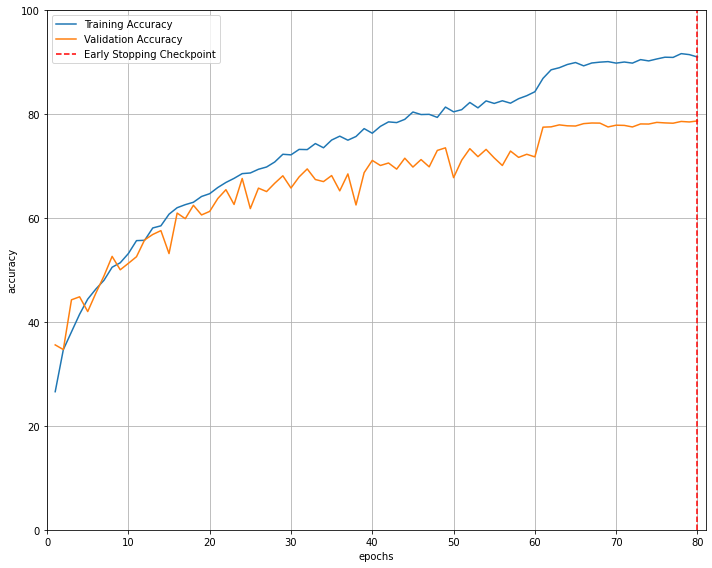

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, label='Training Accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,label='Validation Accuracy')

# validation Accuracy의 최대값 지점을 찾기
maxposs = val_accuracy.index(max(val_accuracy))+1
plt.axvline(maxposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 100) # 일정한 scale
plt.xlim(0, len(train_accuracy)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('accuracy_plot.png', bbox_inches = 'tight')

In [ ]:
test(model, test_loader, criterion)

Epoch: 1. Validate.: 100%|██████████| 79/79 [00:33<00:00,  2.34it/s]


Test Loss: 0.8001, Accuracy: 78.72%


(0.8001340969085693, 78.72)

# 기본 ResNet과 SE-ResNet과 비교
        

ResNet과 SE-ResNet을 유일하게 SEBlock만 차이를 두고 같은 조건으로 실험을 진행.

* ResNet의 경우
    
    77회에서 early stop
    
    Test Loss: 0.7529, Accuracy: 75.32%

    한번의  epoch당 1분 17초 정도의 시간

---


* SE-ResNet의 경우

    80회에서 early stop

    Test Loss: 0.8001, Accuracy: 78.72%

    한번의  epoch당 2분 50초 정도의 시간
